In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer


from digitech_classify.pipeline.config import DATA_DIR, PROCESSED_DATA_DIR
from digitech_classify.pipeline.data_engineering.features import batch_lemmatize, nlp_fast


In [15]:
df = pd.read_excel(PROCESSED_DATA_DIR / "mutlilabelled_training_set_enriched_v2.xlsx")

y_train = df["all_sectors"]   


In [11]:
companies_df = pd.read_csv(PROCESSED_DATA_DIR / "company_tagged_all-MiniLM-L6-v2.csv")
print("Companies DataFrame shape:", companies_df.shape)
print("Unique labels in 'keyword':", companies_df['keyword'].nunique())


Companies DataFrame shape: (107335, 5)
Unique labels in 'keyword': 1627


In [25]:
parsed_labels = y_train.apply(lambda x: list(ast.literal_eval(x)))
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(parsed_labels)


In [ ]:
print("Encoded labels shape:", y_encoded.shape)
print("Classes:", mlb.classes_)

In [ ]:

label_counts = pd.Series(y_encoded.sum(axis=0), index=mlb.classes_).sort_values(ascending=False)

# bar plot + threshold
ax = label_counts.plot(kind='barh', figsize=(8,5))
ax.axvline(500, ls='--', lw=1, label='500-positive floor')
plt.legend()
plt.gca().invert_yaxis()
plt.title('Current positive counts per label')
plt.show()


In [6]:
kw_df = pd.read_excel(DATA_DIR / "keywords_combined_digital/Keywords_Combined.xlsx", sheet_name="Sheet1")
kw_df['Keyword'] = kw_df['Keyword'].astype(str).str.strip().str.lower()
kw_df = kw_df[kw_df['yes/no'] == 'yes']
kw_df = kw_df.drop(columns=['yes/no', 'Subcluster', 'Cluster'])
kw_df['Sector'] = kw_df['Sector'].astype(str).str.strip().str.lower()

kw_df['keywords_lemma'] = batch_lemmatize(
    kw_df['Keyword'].tolist(), model=nlp_fast, batch_size=5000
)

Processing texts: 100%|██████████| 2057/2057 [00:00<00:00, 9053.85it/s] 


In [7]:
# Merge companies_df with kw_df to add sector information
companies_df = companies_df.merge(
    kw_df[['keywords_lemma', 'Sector']], 
    left_on='keyword', 
    right_on='keywords_lemma', 
    how='left'
)

# Drop the redundant keywords_lemma column
companies_df = companies_df.drop(columns=['keywords_lemma'])


In [ ]:
quantum_df = companies_df[
    (companies_df['similarity'] >= 0.65) & 
    (companies_df['Sector'].str.contains('quantum technologies', case=False, na=False))
]


print(quantum_df.head())

In [ ]:
quantum_df = quantum_df.groupby('org_ID').agg({
    'organisation_name': 'first',
    'keyword': list,
    'similarity': list,
    'search_text': 'first'
}).reset_index()



In [ ]:
HPC_df = companies_df[
    (companies_df['similarity'] >= 0.7) & 
    (companies_df['Sector'].str.contains('high performance computing', case=False, na=False))
]

HPC_df = HPC_df.groupby('org_ID').agg({
    'organisation_name': 'first',
    'keyword': list,
    'similarity': list,
    'search_text': 'first'
}).reset_index()



In [ ]:
robotics_df = companies_df[
    (companies_df['similarity'] >= 0.7) & 
    (companies_df['Sector'].str.contains('robotics', case=False, na=False))
]

robotics_df = robotics_df.groupby('org_ID').agg({
    'organisation_name': 'first',
    'keyword': list,
    'similarity': list,
    'search_text': 'first'
}).reset_index()



In [ ]:
robotics_df['sector'] = 'robotics'
HPC_df['sector'] = 'high performance computing'

In [8]:
semiconductor_df = companies_df[
    (companies_df['similarity'] >= 0.7) & 
    (companies_df['Sector'].str.contains('microelectronics and semiconductors', case=False, na=False))
]

semiconductor_df = semiconductor_df.groupby('org_ID').agg({
    'organisation_name': 'first',
    'keyword': list,
    'similarity': list,
    'search_text': 'first'
}).reset_index()

In [ ]:
# Add sector column to quantum_companies
quantum_df['sector'] = 'quantum technologies'

# Then combine all three sector dataframes
sector_companies = pd.concat([robotics_df, HPC_df, quantum_df], ignore_index=True)
print("Sector companies DataFrame shape:", sector_companies.shape)

In [ ]:
# Add companies that are only in sector_companies but not in df
sector_companies = sector_companies[~sector_companies['org_ID'].isin(df['org_ID'])].copy()


In [ ]:
semiconductor_tagged_df = pd.read_csv(PROCESSED_DATA_DIR / "semiconductor_tagged_companies.csv")


In [16]:

enrich_df = semiconductor_tagged_df[~semiconductor_tagged_df['org_ID'].isin(df['org_ID'])].copy()
print("Enrich DataFrame shape:", enrich_df.shape)

Enrich DataFrame shape: (515, 5)


In [17]:
semiconductor_tagged_df.shape

(522, 5)

In [19]:

# Create a DataFrame with the same structure as df for sector-only companies
sector_only_df = pd.DataFrame({
    'org_ID': enrich_df ['org_ID'],
    'organisation_name': enrich_df ['organisation_name'],
    'all_sectors': enrich_df ['Sector'], 
    'search_text': enrich_df ['search_text'],
})
sector_only_df['all_sectors'] = sector_only_df['all_sectors'].apply(lambda x: {x})



In [20]:
sector_only_df = sector_only_df[sector_only_df['all_sectors'] != {'advanced digital communications and connectivity'}]

In [21]:

# Combine the enriched df with sector-only companies
df_enriched = pd.concat([df, sector_only_df], ignore_index=True)


In [22]:
df_enriched.shape

(26437, 4)

In [26]:
# Parse and encode labels for the enriched dataset
parsed_labels_enriched = df_enriched["all_sectors"].apply(lambda x: list(x) if isinstance(x, set) else list(ast.literal_eval(x)))
y_encoded_enriched = mlb.transform(parsed_labels_enriched)

# Calculate label counts for enriched dataset
label_counts_enriched = pd.Series(y_encoded_enriched.sum(axis=0), index=mlb.classes_).sort_values(ascending=False)


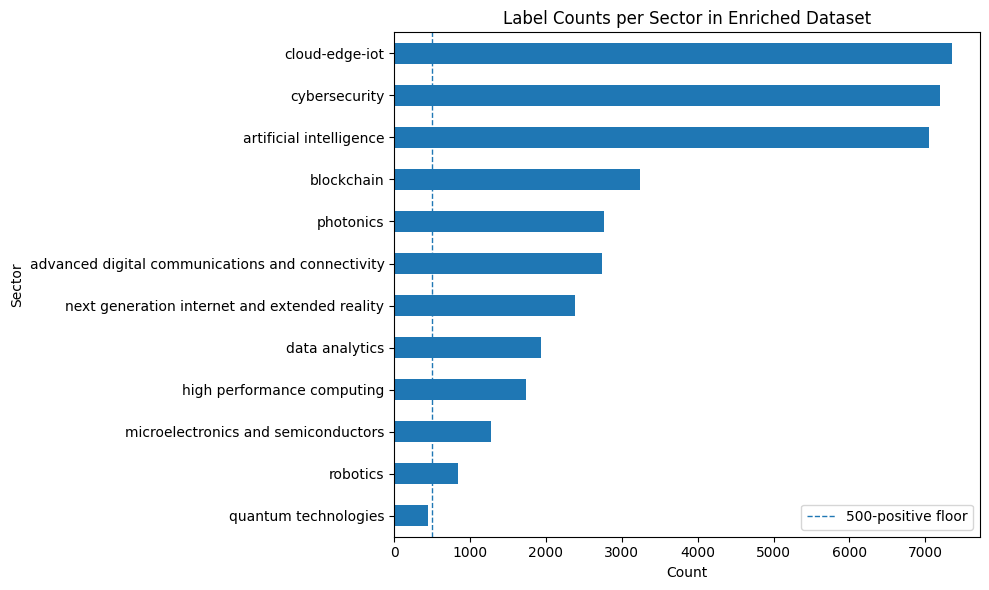

In [27]:

# Create bar plot for enriched dataset
ax = label_counts_enriched.plot(kind='barh', figsize=(10,6))
ax.axvline(500, ls='--', lw=1, label='500-positive floor')
plt.legend()
plt.gca().invert_yaxis()
plt.title('Label Counts per Sector in Enriched Dataset')
plt.xlabel('Count')
plt.ylabel('Sector')
plt.tight_layout()
plt.show()


In [28]:
save_path = PROCESSED_DATA_DIR / "multilabelled_training_set_enriched_v2.csv"
df_enriched.to_csv(save_path, index=False)